# `utils_trajectories`

In [ ]:
#| default_exp utils_trajectories

In [ ]:
#| export    
import numpy as np    

In [ ]:
#| hide
import matplotlib.pyplot as plt
from nbdev import show_doc

# Probability distributions

### Pert distribution

In [ ]:
#| export 
def pert(params:list, # Pert parameters a, b, c
         size:int = 1, # number of samples to get
         lamb = 4 # lambda pert parameters
        )-> np.array: # samples from the given Pert distribution
    ''' 
    Samples from a Pert distribution of given parameters
    '''
    if isinstance(params, float) or isinstance(params, int):
        if size == 1:
            return params
        else:
            return np.array(params).repeat(size)
    
    a, b, c = params
    # if all parameters are the same, we consider it a delta distribution
    if a == b == c:
        return np.array([a]*size)
    r = c - a
    alpha = 1 + lamb * (b - a) / r
    beta = 1 + lamb * (c - b) / r
    return a + np.random.beta(alpha, beta, size=size) * r

### Gaussian distribution

In [ ]:
#| export
import scipy.stats
def gaussian(params:list|int, # If list, mu and sigma of the gaussian. If int, we consider sigma = 0
             size = 1,  # Number of samples to get.
             bound = None # Bound of the Gaussian, if any.
            )-> np.array: # Samples from the given Gaussian distribution
    '''
    Samples from a Gaussian distribution of given parameters.
    '''
    # if we are given a single number, we consider equal to mean and variance = 0
    if isinstance(params, float) or isinstance(params, int):
        if size == 1:
            return params
        else:
            return np.array(params).repeat(size)
    else:
        mean, var = params        
        if bound is None:
            val = np.random.normal(mean, np.sqrt(var), size)
        if bound is not None:
            lower, upper = bound
            if var == 0: 
                if mean > upper or mean < lower:
                    raise ValueError('Demanded value outside of range.')
                val = np.ones(size)*mean
            else:
                val = scipy.stats.truncnorm.rvs((lower-mean)/np.sqrt(var),
                                                (upper-mean)/np.sqrt(var),
                                                loc = mean,
                                                scale = np.sqrt(var),
                                                size = size)
        if size == 1:
            return val[0]
        else:
            return val

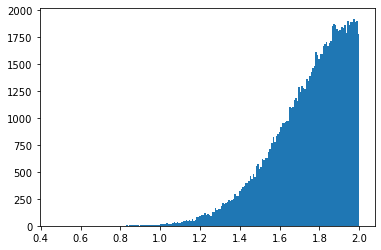

In [ ]:
k = gaussian([2, 0.1], size = int(1e5), bound = [0, 2])
plt.hist(k, bins = 200);

### Sampler random points in the surface of a sphere

In [ ]:
#| export    
def sample_sphere(N:int, # Number of points to generate.
                  # Radius of the sphere. If int, all points have
                  # the same radius, if numpy.array, each number has different radius.
                  R:int|list, 
                 )->np.array: # Sampled numbers
    '''
    Samples random number that lay in the surface of a 3D sphere centered in 
    zero and with radius R.
    '''
    vecs = np.random.randn(3, N)
    vecs /= np.linalg.norm(vecs, axis=0)
    return R*vecs

# 1D Brownian motion

In [ ]:
#| export    
def bm1D(T:int, # Length of the trajecgory
         D:float, # Diffusion coefficient
         deltaT = False # Sampling time
        )-> np.array: # Brownian motion trajectory
    '''Creates a 1D Brownian motion trajectory'''
    if D < 0:
        raise ValueError('Only positive diffusion coefficients allowed.') 
    if not deltaT:               
        deltaT = 1
    return np.cumsum(np.sqrt(2*D*deltaT)*np.random.randn(int(T)))        
     

# Regularize and normalize

## Regularize trajectory with irregular sampling times

In [ ]:
#| export    
def regularize(positions:np.array, # Positions of the trajectory to regularize
               times:np.array, # Times at which previous positions were recorded
               T:int # Length of the output trajectory
              )->np.array: # Regularized trajectory.
    '''
    Regularizes a trajectory with irregular sampling times.
    ''' 
    times = np.append(0, times)
    pos_r = np.zeros(T)
    for idx in range(len(times)-1):
        pos_r[int(times[idx]):int(times[idx+1])] = positions[idx]
    pos_r -= pos_r[0]
    return pos_r

## Normalize displacements of a trajectory

In [ ]:
#| export    
def normalize(trajs):    
    '''
    Normalizes trajectories by substracting average and dividing by
    SQRT of their standard deviation.
    
    Parameters
    ----------
    trajs : np.array
        Array of length N x T or just T containing the ensemble or single trajectory to normalize. 
    '''
    # Checking and saving initial shape
    initial_shape = trajs.shape
    if len(trajs.shape) == 1: # single one d trajectory
        trajs = trajs.reshape(1, trajs.shape[0], 1)
    if len(trajs.shape) == 2: # ensemble of one d trajectories
        trajs = trajs.reshape(trajs.shape[0], trajs.shape[1], 1)
        
    trajs = trajs - trajs.mean(axis=1, keepdims=True)
    displacements = (trajs[:,1:,:] - trajs[:,:-1,:]).copy()    
    variance = np.std(displacements, axis=1)
    variance[variance == 0] = 1    
    new_trajs = np.cumsum((displacements/np.expand_dims(variance, axis = 1)), axis = 1)
    initial_zeros = np.expand_dims(np.zeros((new_trajs.shape[0], new_trajs.shape[-1])), axis = 1)
    return np.concatenate((initial_zeros, new_trajs), axis = 1).reshape(initial_shape)

In [ ]:
#| export
def normalize_fGN(disp, alpha, D, T: int, deltaT : int = 1):
    '''
    Normalizes fractional Gaussian Noise created with `stochastic` library.

    Parameters
        ----------
        disp : Array-like of shape N x T or just T containing the displacements to normalize.
        alpha : float in [0,2] or array-like of length N x 1
            Anomalous exponent
        D : float or array-like of shape N x 1
            Diffusion coefficient
        T : int
            Number of timesteps the displacements were generated with
        deltaT : int, optional
            Sampling time

        Returns
        -------
            Array-like containing T displacements of given parameters
    '''
    return disp*np.sqrt(T)**(alpha)*np.sqrt(2*D*deltaT)

In [ ]:
#| hide
import numpy as np

Text(0, 0.5, 'Position')

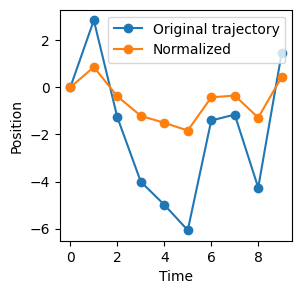

In [ ]:
N = 10; T = 10
trajs = 3*np.random.randn(N*T*2).reshape(N,T,2)
trajs = np.cumsum(trajs, axis = 1)

norm_trajs = normalize(trajs)

idx = 0; plt.figure(figsize = (3,3))
plt.plot(trajs[idx,:,0]-trajs[idx,0,0], '-o', label = 'Original trajectory')
plt.plot(norm_trajs[idx,:,0], '-o', label = 'Normalized')
plt.legend(); plt.xlabel('Time'); plt.ylabel('Position')

# Trigonometry functions

Needed for the correct calculation of confined diffusion in circular compartments.

In [ ]:
#| export
import math

class trigo():
    
    '''
    This class gathers multiple useful trigonometric relations.
    
    Inspired from:
    https://stackoverflow.com/questions/30844482/what-is-most-efficient-way-to-find-the-intersection-of-a-line-and-a-circle-in-py 
    and http://mathworld.wolfram.com/Circle-LineIntersection.html'''

    def circle_line_segment_intersection(circle_center, circle_radius, 
                                         pt1, pt2, 
                                         full_line=False, tangent_tol=1e-9):
        """ 
        Find the points at which a circle intersects a line-segment. This can happen at 0, 1, or 2 points.
        
        Parameters
        ----------
        circle_center : tuple
            The (x, y) location of the circle center
        circle_radius : float
            The radius of the circle
        pt1 : tuple
            The (x, y) location of the first point of the segment
        pt2 : tuple
            The (x, y) location of the second point of the segment
        full_line : bool
            True to find intersections along full line - not just in the segment. 
            False will just return intersections within the segment.
        tangent_tol : float
            Numerical tolerance at which we decide the intersections are close enough to consider it a tangent
        
        Returns
        -------
        Sequence[Tuple[float, float]]
            A list of length 0, 1, or 2, where each element is a point at which the circle intercepts a line segment.

        """

        (p1x, p1y), (p2x, p2y), (cx, cy) = pt1, pt2, circle_center
        (x1, y1), (x2, y2) = (p1x - cx, p1y - cy), (p2x - cx, p2y - cy)
        dx, dy = (x2 - x1), (y2 - y1)
        dr = (dx ** 2 + dy ** 2)**.5
        big_d = x1 * y2 - x2 * y1
        discriminant = circle_radius ** 2 * dr ** 2 - big_d ** 2

        if discriminant < 0:  # No intersection between circle and line
            return []
        else:  # There may be 0, 1, or 2 intersections with the segment
            intersections = [
                (cx + (big_d * dy + sign * (-1 if dy < 0 else 1) * dx * discriminant**.5) / dr ** 2,
                 cy + (-big_d * dx + sign * abs(dy) * discriminant**.5) / dr ** 2)
                for sign in ((1, -1) if dy < 0 else (-1, 1))]  # This makes sure the order along the segment is correct
            if not full_line:  # If only considering the segment, filter out intersections that do not fall within the segment
                fraction_along_segment = [(xi - p1x) / dx if abs(dx) > abs(dy) else (yi - p1y) / dy for xi, yi in intersections]
                intersections = [pt for pt, frac in zip(intersections, fraction_along_segment) if 0 <= frac <= 1]
            if len(intersections) == 2 and abs(discriminant) <= tangent_tol:  # If line is tangent to circle, return just one point (as both intersections have same location)
                return [intersections[0]]
            else:
                return intersections
            
    def seg_to_vec(seg):
        ''' Find the vector given a segment created by two 2D points'''
        return [(seg[0][0]-seg[1][0]), (seg[0][1]-seg[1][1])]

    def ang_line(lineA, lineB):
        ''' Calculates the angle between two lines/segments'''
        # Get vector form
        vA = trigo.seg_to_vec(lineA)
        vB = trigo.seg_to_vec(lineB)
        return trigo.ang_vec(vA, vB)

    def ang_vec(vA, vB):
        ''' Calculates the angle between two vectors'''
        # Get dot prod
        dot_prod = np.dot(vA, vB)
        # Get magnitudes
        magA = np.dot(vA, vA)**0.5
        magB = np.dot(vB, vB)**0.5
        # Get cosine value
        cos_ = dot_prod/magA/magB
        # Get angle in radians and then convert to degrees
        return math.acos(dot_prod/magB/magA)    
    
    def rotate_vec(vec, angle):
        return (vec[0]*np.cos(angle) + vec[1]*np.sin(angle), -vec[0]*np.sin(angle) + vec[1]*np.cos(angle))
    

In [ ]:
show_doc(trigo.circle_line_segment_intersection)

# Adding field of view (FOV)

In [ ]:
#| export
def find_nan_segments(a, cutoff_length):    
    ''' Extract all segments of nans bigger than the set cutoff_length. If no segments are found, returns None. 
    For each segments, returns the begining and end index of it.
    
    Output: array of size (number of segments) x 2.
    '''
    mask = np.concatenate(([False],np.isnan(a),[False]))
    if ~mask.any():
        return None
    else:
        idx = np.nonzero(mask[1:] != mask[:-1])[0]
        seg_length = (idx[1::2] - idx[::2])
        idx_seg_long = np.argwhere(seg_length >= cutoff_length).flatten()
        if idx_seg_long.shape[0] == 0: 
            return None
        else:
            return np.array([idx[::2][idx_seg_long], idx[1::2][idx_seg_long]]).transpose()

In [ ]:
#| export
def segs_inside_fov(traj, fov_origin, fov_length, cutoff_length):
    ''' 
    Given a trajectory, finds the segments inside the field of view (FOV).
    
    Parameters
    ----------
    traj : array
        Set of trajectories of size N x T (N: number trajectories, T: length).
    fov_origin : tuple
        Bottom right point of the square defining the FOV.
    fov_length : float
        Size of the box defining the FOV.
    cutoff_length : float
        Minimum length of a trajectory inside the FOV to be considered in the output dataset.
    
    Returns
    -------
    array
         Set of segments inside the FOV.
    '''
    
    import warnings
    warnings.filterwarnings('ignore') # nanmin gives an undesired warning..
    
    fov_min_x, fov_min_y = fov_origin
    fov_max_x, fov_max_y = np.array(fov_origin)+fov_length
        
    # extract components
    x, y = traj[:, 0].copy(), traj[:, 1].copy()
    
    
    # Interior points to the FOV are set to nans
    x[np.argwhere((x > fov_min_x) & (x < fov_max_x))] = np.nan
    y[np.argwhere((y > fov_min_y) & (y < fov_max_y))] = np.nan

    # Compare the minimums of each array. This way, if at least one dimension
    # is outside (i.e. not nan), the whole segment will be considered outside
    merge_dims = np.nanmin(np.vstack((x, y)), axis = 0)
    
    # Find nan segments bigger than cutoff_length
    nan_segms = find_nan_segments(merge_dims, cutoff_length = cutoff_length)
    
    return nan_segms
    

In [ ]:
#| export
def inside_fov_dataset(trajs, labels, 
                       fov_origin, fov_length, 
                       cutoff_length = 10, 
                       func_labels = None,
                       return_frames = False):
    ''' Given a dataset of trajectories with labels and a FOV parameters, returns a list of
        trajectories with the corresponding labels inside the FOV
    
    Parameters
    ----------
    trajs : array
        Set of trajectories with shape T x N x 2.
    labels : array
        Set of labels with shape T x N x 2.
    fov_origin : tuple
        Bottom left point of the square defining the FOV.
    fov_length : float
        Size of the box defining the FOV.
    cutoff_length : float
        Minimum length of a trajectory inside the FOV to be considered in the output dataset.
    func_labels : func
        (optional) Function to be applied to the labels to take advantage of the loop.
    
    Returns
    -------
    tuple
        - trajs_fov (list): list 2D arrays containing the trajectories inside the field of view.
        - labels_fov (list): corresponding labels of the trajectories.
    '''
    
    trajs_fov, labels_fov = [], []
    frames = np.arange(trajs.shape[0])
    for idx, (traj, label) in enumerate(zip(trajs[:, :, :].transpose(1,0,2),
                                            labels[:, :, :].transpose(1,0,2))):
        nan_segms = segs_inside_fov(traj, fov_origin, fov_length, cutoff_length)
    
        if nan_segms is not None:
            for idx_nan in nan_segms:  
                
                traj_x = traj[idx_nan[0]:idx_nan[1], 0]
                traj_y = traj[idx_nan[0]:idx_nan[1], 1]
                if return_frames:
                    frames_cut = frames[idx_nan[0]:idx_nan[1]]
                    trajs_fov.append(np.vstack((frames_cut, traj_x, traj_y)))
                else:
                    trajs_fov.append(np.vstack((traj_x, traj_y)))
                
                
                lab_list = []
                for idx_lab in range(label.shape[-1]):
                    if func_labels is not None: # If feeded, apply func_label (mostly for smoothing)
                        lab = func_labels(label[idx_nan[0]:idx_nan[1], idx_lab])
                    else:
                        lab = label[idx_nan[0]:idx_nan[1], idx_lab]
                    lab_list.append(lab)        
                    
                labels_fov.append(np.vstack(lab_list))
                
    return trajs_fov, labels_fov
            
    
    

Example: (check notebooks for full details)

In [ ]:
#| hide
from andi_datasets.models_phenom import models_phenom
from andi_datasets.utils_trajectories import inside_fov_dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [ ]:
L = 200; T = 100
Ns = [20,10,10]
alphas = [1,1.5]
D = 1   

trajs, labels = models_phenom().multi_state(N = 500, L = L, T = 50)

fov_origin = [50,50]; fov_length = L*0.1
trajs_fov, labels_fov = inside_fov_dataset(trajs, labels, fov_origin, fov_length)

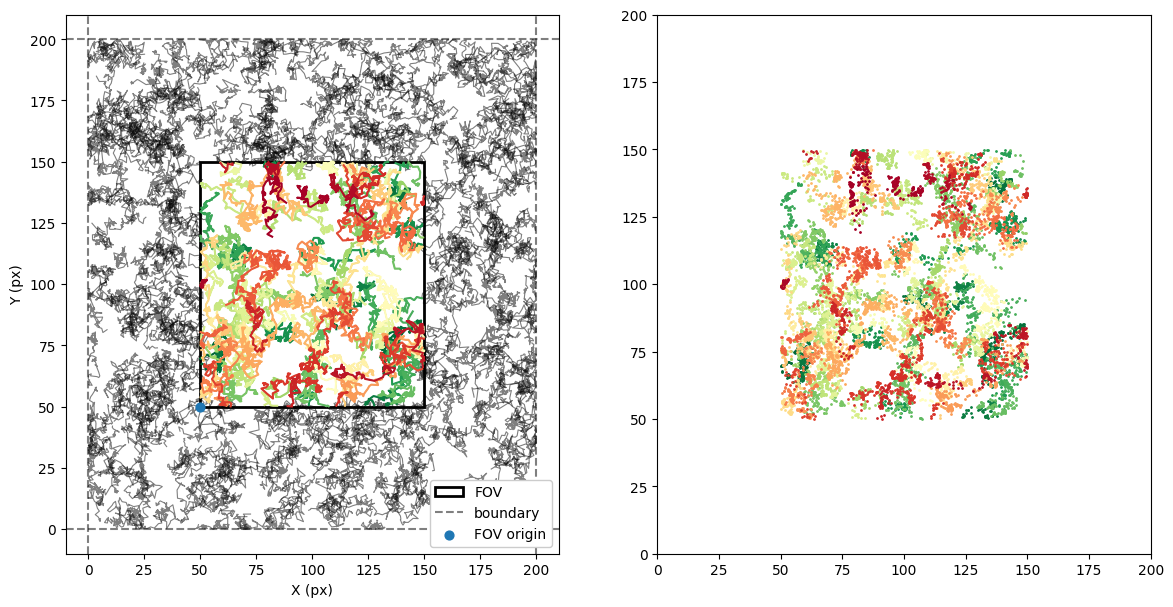

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize = (14,7))
colors = plt.cm.RdYlGn(np.linspace(0, 1, len(trajs_fov)))

for idx, og_traj in enumerate(trajs[:, :, :].transpose(1,0,2)):
    ax.plot(og_traj[:, 0], og_traj[:, 1], c = 'k', alpha = 0.5, lw = 0.8)

for t, c in zip(trajs_fov, colors[::-1, :]):
    ax.plot(t[0], t[1], c= c)
    ax2.scatter(t[0], t[1], facecolor = c, s = 1)

# FOV
fov_min_x, fov_min_y = fov_origin
fov_max_x, fov_max_y = np.array(fov_origin)+fov_length
# currentAxis = ax.gca()
ax.add_patch(Rectangle((fov_min_x, fov_min_y), fov_length, fov_length, fill=None, alpha=1, lw = 2, label = 'FOV'))


# Boundary
ax.axhline(0,  alpha = 0.5, ls = '--', c = 'k', label = 'boundary')
ax.axhline(L,  alpha = 0.5, ls = '--', c = 'k')
ax.axvline(0,  alpha = 0.5, ls = '--', c = 'k')
ax.axvline(L,  alpha = 0.5, ls = '--', c = 'k')

# FOV origin
ax.scatter(fov_origin[0], fov_origin[1], label = 'FOV origin', s = 40, zorder = 10)

legend = ax.legend()
legend.get_frame().set_alpha(None)
plt.setp(ax, xlabel = 'X (px)', ylabel = 'Y (px)')
plt.setp(ax2, xlim = (0,L), ylim = (0,L));

# Motion Blur

In [ ]:
#| export
class motion_blur():
    ''' 
    Applies a motion blur to given trajectories. Motion blur is apply by considering an oversampled trajectory and then averaging the
    position over the exposure time. The oversampling is controled by the oversampling factor O.
    
    If we want to generate trajectories of size T, we must input trajectories of size T*O. The trajectory is then reshape into chunks of size O.
    The output position for each chunk is the average over the exposure time, i.e. the percentage of the beginning of this chunk.
    '''
    
    def __init__(self, 
                 output_length: int, # Expected length of trajectories after applying motion blur
                 oversamp_factor:float = 10, # Oversampling factor. This implies that the number of frames goes from input -> T*O to  output -> T
                 exposure_time:float = 0.5 # Percentage of the oversampled (i.e in [0,1])
                ):    
        
        self.output_length = output_length
        self.oversamp_factor = oversamp_factor
        
        self.input_length = self.output_length*self.oversamp_factor
        
        self.exposure_time = int(exposure_time*self.oversamp_factor)        
        
    def apply(self, 
              trajs:np.array, # Input trajectories. Must be of size (input_length, num_trajs, dimension)
             )-> np.array: # Output trajectories after applying motion blur. Size: (input_length / oversamp_factor, num_trajs, dimension)
        '''
        Applies the motion blur with the parameters defined.
        '''
        if trajs.shape[0] != self.input_length:
            raise ValueError(f'Input size ({trajs.shape[0]}) of the trajectories does not coincide with expected ({self.input_length}) '
                             +'for proper application of motion blur.')
            
        trajs_reshape = trajs.reshape(self.output_length, 
                                      self.oversamp_factor, 
                                      trajs.shape[1], trajs.shape[2])
        
        return np.mean(trajs_reshape[:, :self.exposure_time], axis=1)

In [ ]:
show_doc(motion_blur.apply)

Example:

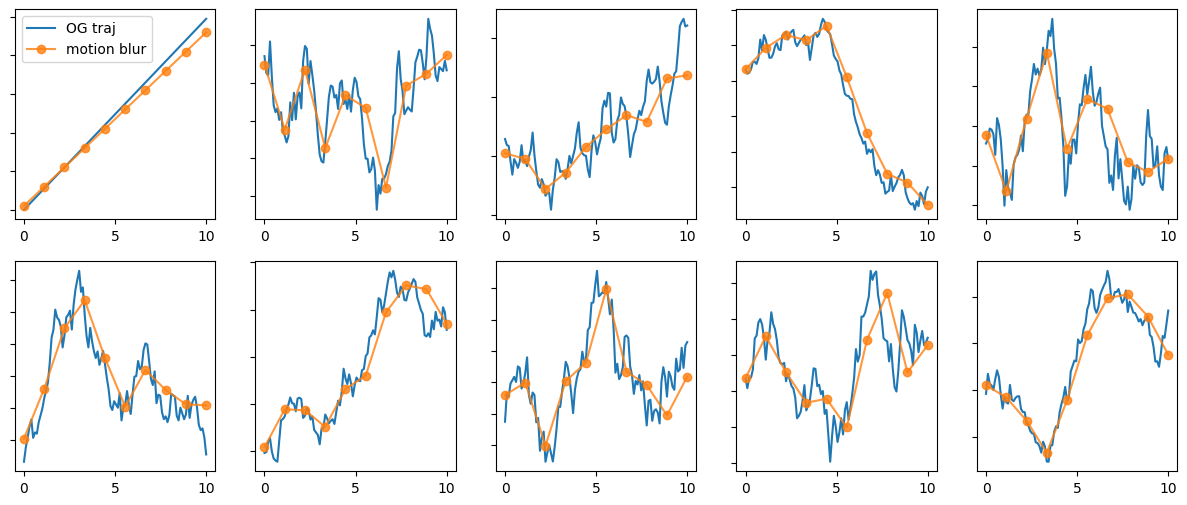

In [ ]:
MB = motion_blur(output_length = 10, oversampling = 10, exposure_time = 0.5)
trajs = np.random.randn(100, 5, 2).cumsum(0)
trajs[:,0,0] = np.arange(100) # we put a straight line to check what happens
mb_trajs = MB.apply(trajs)

_, axs = plt.subplots(2,5,figsize = (15,6))

for t, t_mb, ax in zip(trajs.transpose(1,0,2), mb_trajs.transpose(1,0,2), axs.transpose()):
    
    ax[0].plot(np.linspace(0,10,t.shape[0]), t[:,0], label = 'OG traj')
    ax[0].plot(np.linspace(0,10,t_mb.shape[0]), t_mb[:,0], 'o-', alpha = 0.8, label = 'motion blur')
    
    ax[1].plot(np.linspace(0,10,t.shape[0]), t[:,1])
    ax[1].plot(np.linspace(0,10,t_mb.shape[0]), t_mb[:,1], 'o-', alpha = 0.8)
axs[0,0].legend()
plt.setp(axs, yticklabels = []);

# Plotting trajectories

In [ ]:
#| export
import matplotlib.pyplot as plt

def plot_trajs(trajs, L , N, 
               num_to_plot = 3,
               labels = None,
               plot_labels = False,
               traps_positions = None,
               comp_center = None, r_cercle = None
              ):
    
    if plot_labels:
        fig, axs = plt.subplots(3, num_to_plot, figsize = (num_to_plot*3, 3*3), tight_layout = True)
    else:
        fig, axs = plt.subplots(2, num_to_plot, figsize = (num_to_plot*3, 2*3), tight_layout = True)

    for ax in axs.transpose():
        
        if traps_positions is not None:
            ax[0].scatter(traps_positions[:,0], traps_positions[:,1], c = 'C1')
            
        if comp_center is not None:
            for c in comp_center:
                circle = plt.Circle((c[0], c[1]), r_cercle, facecolor = 'None', edgecolor = 'C1', zorder = 10)
                ax[0].add_patch(circle) 

        
        part = np.random.randint(N)    
        ax[0].set_title(f'Particle # {part}')
        ax[0].plot(trajs[:, part, 0], trajs[:, part, 1], alpha = 0.8)
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k', label = 'Boundary')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')

        ax[1].plot(trajs[:, part, 0], 'o-', label = 'X', ms = 3, lw = 0.1)
        ax[1].plot(trajs[:, part, 1], 'o-', label = 'Y', ms = 3, lw = 0.1)
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        
        if plot_labels:
            ax[2].plot(labels[:, part, 0], 'o-', label = r'$\alpha$', ms = 3, lw = 0.1)
            ax[2].plot(labels[:, part, 1], 'o-', label = r'$D$', ms = 3, lw = 0.1)


    plt.setp(axs[0, :], xlabel = 'X', ylabel = 'Y')
    axs[0, 0].legend()
    axs[1, 0].legend()
    plt.setp(axs[1, 0], ylabel = 'Position')
    plt.setp(axs[1:-1, :], xticklabels = '')
   
    if plot_labels:
        axs[2, 0].legend()
        plt.setp(axs[2, 0], ylabel = 'Labels')
        plt.setp(axs[2, :], xlabel = 'Time');
    else:
        plt.setp(axs[1, :], xlabel = 'Time');
        

In [ ]:
#| hide
from andi_datasets.models_phenom import models_phenom

In [ ]:
T = 50; N = 50; L = 1.2*128; D = 0.1

trajs_model1, labels = models_phenom().single_state(N = N, 
                                            L = L,
                                            T = T,
                                            Ds = D,
                                            alphas = 0.5
                                            )

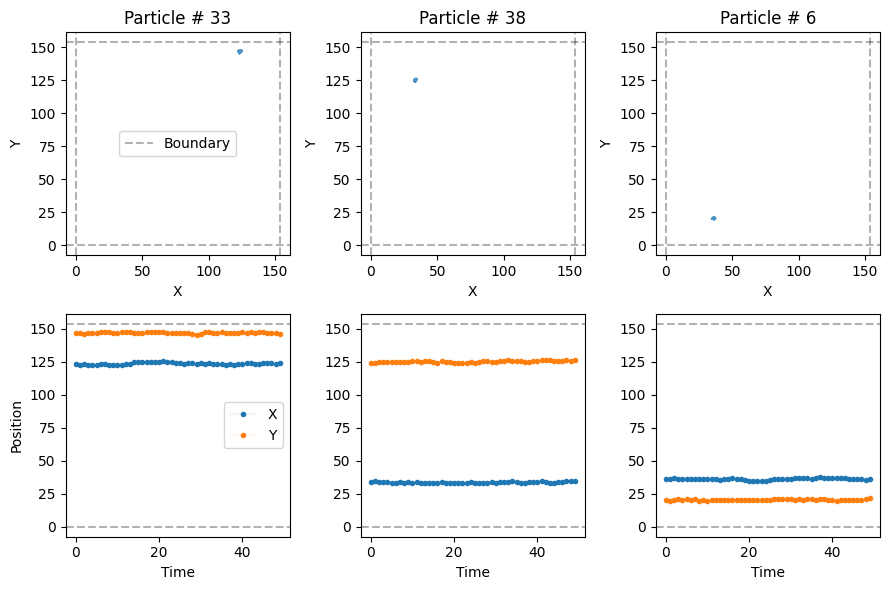

In [ ]:
plot_trajs(trajs_model1, L, N)

#| hide
# nbdev

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()